# The Weibull Distribution

The Weibull distribution is a continuous probability distribution that was first applied by Rosin and Rammler to describe particle distributions in the communition of coal 1933. The distribution was first proposed purely empirically, but has been derived through describing the branching of cracks for a [particle with a fractal cracking process](https://permalink.lanl.gov/object/tr?what=info:lanl-repo/lareport/LA-UR-94-3297). The Weibull distribution is also used extensively in failure analysis. The general form of the Weibull distribution is as follows:

$$ f(x;\lambda,k) =
\begin{cases}
\frac{k}{\lambda}\left(\frac{x}{\lambda}\right)^{k-1}e^{-(x/\lambda)^{k}} & x\geq0 ,\\
0 & x<0,
\end{cases} $$

where $x$ is a random variable, $\lambda$ is the scale parameter, and $k$ is the shape parameter. More specifically to a communition process, the Weibull distribution can be re-written as follows:    

$$f(x;P_{\rm{80}},m) =  \begin{cases}
1-e^{\ln\left(0.2\right)\left(\frac{x}{P_{\rm{80}}}\right)^m} & x\geq0 ,\\
0 & x<0 ,\end{cases}$$

where $x$ is the particle size, $P_{80}$ is the 80th percentile of the grind distribution, and $m$ is the spread parameter.



## Fitting a filter coffee grind distribution

First, we load data from [photo analysis](https://coffeeadastra.com/2019/04/07/an-app-to-measure-your-coffee-grind-size-distribution-2/). The grinder in question is a Kafatek Monolith Max fitted with 98mm SSP LU red-speed burrs, and the coffee is an Ethiopian Worka from Passenger Coffee.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
df = pd.read_csv("worka_data.csv")
df["DIAMETER"] = (2*np.sqrt(df["LONG_AXIS"]*df["SHORT_AXIS"]))/df["PIXEL_SCALE"]
mass_sum = df["VOLUME"].sum()
df["MASS_FRACTION"] = df["VOLUME"]/mass_sum
df.head()

,ID,SURFACE,ROUNDNESS,SHORT_AXIS,LONG_AXIS,VOLUME,PIXEL_SCALE,DIAMETER,MASS_FRACTION
0,0,81.0,0.342662,2.972354,8.674305,240.760644,12.831,0.791475,0.002281
1,1,144.0,0.611643,5.294869,8.656801,762.461090,12.831,1.055300,0.007225
2,2,129.0,0.600944,4.967491,8.266140,640.806345,12.831,0.998825,0.006072
3,3,87.0,0.344702,3.089633,8.963189,268.798040,12.831,0.820265,0.002547
4,4,72.0,0.536891,3.507795,6.533538,252.561252,12.831,0.746210,0.002393


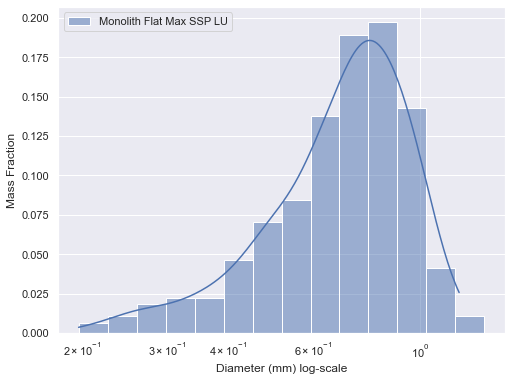

In [3]:
sns.set()
sns.set(rc={'figure.figsize':(8,6)})
plot = sns.histplot(data=df, x=df["DIAMETER"], 
             weights=df["VOLUME"],
             stat="probability",
             log_scale=True,kde=True,
             label="Monolith Flat Max SSP LU",
             binwidth=0.06)
plot.set(xlabel="Diameter (mm) log-scale",ylabel="Mass Fraction")
plot.legend()

Parameter estimation can be done by linearizing the cumulative distribution, with the form:

$$\ln\left(-\ln\left(1-F\right)\right) = 
m\ln(x)+ \ln\left(\frac{-\ln(0.2)}{(P_{\rm{80}})^m}\right)$$

Where $F$ is the mass fraction. $m$ can be found via evaluating the slope of the graph and $P_{80}$ can be calculated with the y-intercept. 


In order to calculate the mass fraction, we calculate and extract the empirical CDF of the distribution.

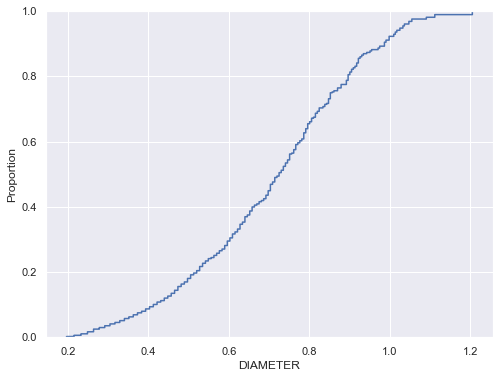

In [4]:
plot1 = sns.ecdfplot(data=df,x=df["DIAMETER"],weights=df["VOLUME"])
line = plot1.lines[0]
diameter = line.get_xdata()
F = line.get_ydata()

Now, we rearrange the Weibull distribution to a linear function and use a polynomial fit.

[Text(0.5, 0, 'ln(diameter)'), Text(0, 0.5, 'ln(-ln(1-F))')]

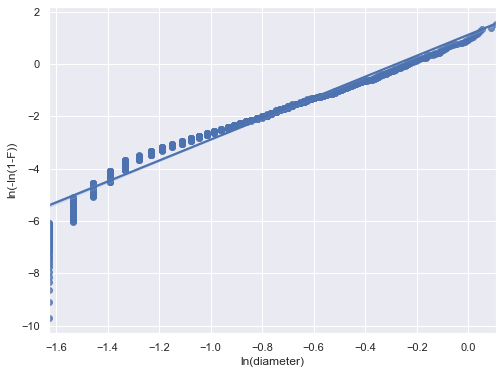

In [5]:
x1 = np.log(diameter[1:-1])
y1 = np.log(-np.log(1-F[1:-1]))
plot2 = sns.regplot(x=x1,y=y1,label="Test")
plot2.set(xlabel="ln(diameter)",ylabel="ln(-ln(1-F))")

We now extract the linear fit from the data and calculate the parameters.

$$ \ln \left( 1 - \ln \left( 1 - F \right) \right) = m \ln(x) + b $$
with
$$ m = k $$ and
$$ b = - k \ln(\lambda) $$

m = 3.434133974809221, b = 0.7775459148006884


<AxesSubplot:>

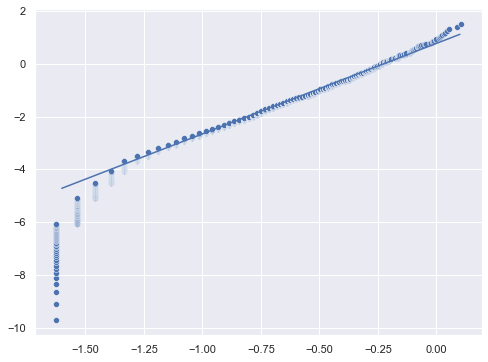

In [6]:
mask = np.logical_not(x1<-1.25)
x_test = x1[mask]
y_test = y1[mask]
m, b = np.polyfit(x_test,y_test,1)
# m, b = np.polyfit(x1,y1,1)
print(f"m = {m}, b = {b}")
goof = np.linspace(-1.6,0.1,num=100)
goof_y = goof*m + b
sns.lineplot(x = goof, y = goof_y)
sns.scatterplot(x = x1, y = y1)

With the linear fit, we can now compute the $\lambda$ and $k$ parameters

In [7]:
k = m
lam = np.exp(-b/k)
print(f"k = {k}, lambda = {lam}")

fit_dia = np.linspace(0.2, 1.2, num=1001)
fit_pdf = (k/lam)*np.power(fit_dia/lam, (k-1))*np.exp(-np.power(fit_dia/lam, k))

k = 3.434133974809221, lambda = 0.7973856148326589


Now plot the PDF of the 

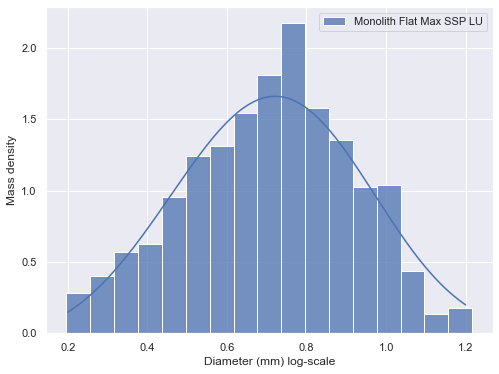

In [8]:
sns.set()
sns.set(rc={'figure.figsize':(8,6)})
sns.lineplot(x = fit_dia, y = fit_pdf)
plot = sns.histplot(data=df, x=df["DIAMETER"], 
             weights=df["VOLUME"],
             stat="density",
             log_scale=False,kde=False,
             label="Monolith Flat Max SSP LU",
             binwidth=0.06)
plot.set(xlabel="Diameter (mm) log-scale",ylabel="Mass density")
plot.legend()